<a href="https://colab.research.google.com/github/mig-projects/journaling-frontend/blob/main/Comparing_semantic_clustering_algorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Libraries load

In [ ]:
!pip install -U sentence-transformers umap-learn scikit-learn openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.0/49.0 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.5/74.5 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.5/374.5 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 49.1 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.5.0
    Uninstalling typing_extensions-4.5.0:
      Successfully uninstalled typing_extensions-4.5.0
  Attempting uninstall: pydantic
    Found existing installation: pydantic 1.10.12
    Uninstalling pydantic-1.10.12:
      Successfully uninstalled pydantic-1.10.12
ERROR: pip's dependency resolver does not currently take into account all the

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans, AgglomerativeClustering, HDBSCAN
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import umap

## Extract embeddings

In [ ]:
# Leveraging SentenceTransformer model to create embeddings meaningful for corpus semantic similarity analysis
# Reference: https://www.sbert.net/index.html
embedder = SentenceTransformer('all-MiniLM-L6-v2')
tag_df = pd.read_csv('/content/drive/Shareddrives/MIGR-AI-TION/research_data/LLM/tag_clustering_results.csv')

# Corpus with user generated tags as of Sep. 6
corpus = list(tag_df.tag_name.to_numpy())
corpus_embeddings = embedder.encode(corpus)
print(corpus_embeddings)

[[-0.15970996  0.08047499 -0.02434523 ...  0.01298409 -0.01672357
   0.03699574]
 [-0.0648718   0.02554536  0.03683447 ... -0.01126003  0.06955916
  -0.01844248]
 [ 0.02795301  0.08739804 -0.02349246 ...  0.01640988  0.05320404
   0.01825775]
 ...
 [-0.09895524  0.08789589 -0.03634287 ... -0.02400519  0.03099344
   0.04579459]
 [-0.01877031  0.05677099 -0.05227696 ... -0.04222667  0.04029132
  -0.03759535]
 [-0.02083639 -0.0120462  -0.0025414  ...  0.04154301 -0.04596369
  -0.03324768]]


## Generating cluster assignments

In [ ]:
# @title Determine the optimal number of clusters (K-Means)
inertia_values = []
cluster_range = range(1, 15)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(corpus_embeddings)
    inertia_values.append(kmeans.inertia_)

# Elbow Method graph


plt.figure(figsize=(10, 6))
plt.plot(cluster_range, inertia_values, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Cluster inertia')
plt.show()

In [ ]:
# @title K-Means Clusters generation

# Perform kmean clustering
num_clusters = 7 # @param {type: "integer"}
clustering_model = KMeans(n_clusters=num_clusters, n_init=10)
clustering_model.fit(corpus_embeddings)

tag_df['kmeans_clusters'] = clustering_model.labels_

kmeans_tags = tag_df.groupby(['kmeans_clusters'])['tag_name'].agg(list).reset_index()
for index, row in kmeans_tags.iterrows():
    print(f"Cluster {row['kmeans_clusters']}: {row['tag_name']}")


Cluster 0: ['startup ', 'small startup.', 'contract signing process']
Cluster 1: ['job', 'discriminated', 'consultant contract', 'not paying', 'internal employee ', 'employment', 'laid off', 'unemployment', '2 times he cancelled our 1-1 meeting', 'garden leave', 'laid off', 'flawed', 'unjust and unfair', 'age', 'HR']
Cluster 2: ['my manager was not the one who interviewed me', "I didn't get any feedback", " I didn't know what else to do", 'without a reply', 'rejected', 'without feedback']
Cluster 3: ['social security contributions', 'contribute more', 'efforts and inputs to justify', 'contribute', 'recruiting process', 'risk', 'pay too much', 'promotion']
Cluster 4: ['start a new life in Berlin', ' language barrier', 'moved to Germany', ' German language skills']
Cluster 5: ['tech', 'psychological impact', 'over compensating', 'different', 'communication', 'uncertainties', 'performance', 'intentions of the management', 'new country', 'open position', 'perfect match', 'administrative re

In [ ]:
# @title Hierarchical clustering (agglomerative)
# Normalize the embeddings to unit length
corpus_embeddings = corpus_embeddings /  np.linalg.norm(corpus_embeddings, axis=1, keepdims=True)
n_clusters = 7 # @param {type: "integer"}

# Perform agglomerative clustering
clustering_model = AgglomerativeClustering(n_clusters=n_clusters, metric='cosine', linkage='average')
clustering_model.fit(corpus_embeddings)

tag_df['agg_clusters'] = clustering_model.labels_

agg_tags = tag_df.groupby(['agg_clusters'])['tag_name'].agg(list).reset_index()
for index, row in agg_tags.iterrows():
    print(f"Cluster {row['agg_clusters']}: {row['tag_name']}")

Cluster 0: ['my manager was not the one who interviewed me', " I didn't know what else to do", '2 times he cancelled our 1-1 meeting']
Cluster 1: ['start a new life in Berlin', 'I was moved to another team', 'moved to Germany', 'new country']
Cluster 2: ['job', 'tech', 'discriminated', 'not paying', 'psychological impact', 'over compensating', 'contribute more', 'different', 'internal employee ', 'employment', 'laid off', 'unemployment', 'communication', 'uncertainties', "didn't know I was hired ", "I didn't get any feedback", 'what was expected of me', 'getting exausted', 'I felt I was failing', 'without a reply', ' I felt this was the moment I would be fired', 'garden leave', ' language barrier', 'performance', 'laid off', 'flawed', 'unjust and unfair', 'open position', 'contribute', 'rejected', 'without feedback', 'outside of the office', 'age', 'excessive experience', 'risk', 'pay too much', 'promotion', ' German language skills', 'HR']
Cluster 3: ['social security contributions']


In [ ]:
# @title HDBSCAN
umap_embeddings = umap.UMAP(n_neighbors=15,
                            n_components=5,
                            metric='cosine').fit_transform(corpus_embeddings)
cluster = HDBSCAN(min_cluster_size=2,

                          cluster_selection_method='eom').fit(umap_embeddings)

tag_df['hdbscan_clusters'] = cluster.labels_

hdbscan_tags = tag_df.groupby(['hdbscan_clusters'])['tag_name'].agg(list).reset_index()
for index, row in hdbscan_tags.iterrows():
    print(f"Cluster {row['hdbscan_clusters']}: {row['tag_name']}")

Cluster -1: ['tech', 'employment', 'unemployment', " I didn't know what else to do", 'flawed', 'open position', 'promotion']
Cluster 0: ['job', 'different', 'age']
Cluster 1: ['startup ', 'small startup.']
Cluster 2: ['perfect match', 'rejected']
Cluster 3: ["I didn't get any feedback", 'without a reply', 'performance', 'without feedback']
Cluster 4: ['communication', ' language barrier', ' German language skills']
Cluster 5: ['start a new life in Berlin', 'moved to Germany', 'new country']
Cluster 6: ['discriminated', 'unjust and unfair']
Cluster 7: ['intentions of the management', 'no clearly defined tasks ']
Cluster 8: ['over compensating', 'efforts and inputs to justify', 'pay too much']
Cluster 9: ['not paying', 'social security contributions', 'contribute more', 'contribute']
Cluster 10: ['what was expected of me', 'getting exausted', 'I felt I was failing']
Cluster 11: ['my manager was not the one who interviewed me', 'I was moved to another team', '2 times he cancelled our 1-1 

## Plotting clusters on a 2-D Map
Leveraging UMAP algorithm to project the tags in 2D space.

In [ ]:
# @title Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(corpus_embeddings)
tag_df = pd.concat([tag_df.drop(['x', 'y'], axis=1, errors='ignore'), pd.DataFrame(umap_data, columns=['x', 'y'])], axis=1)

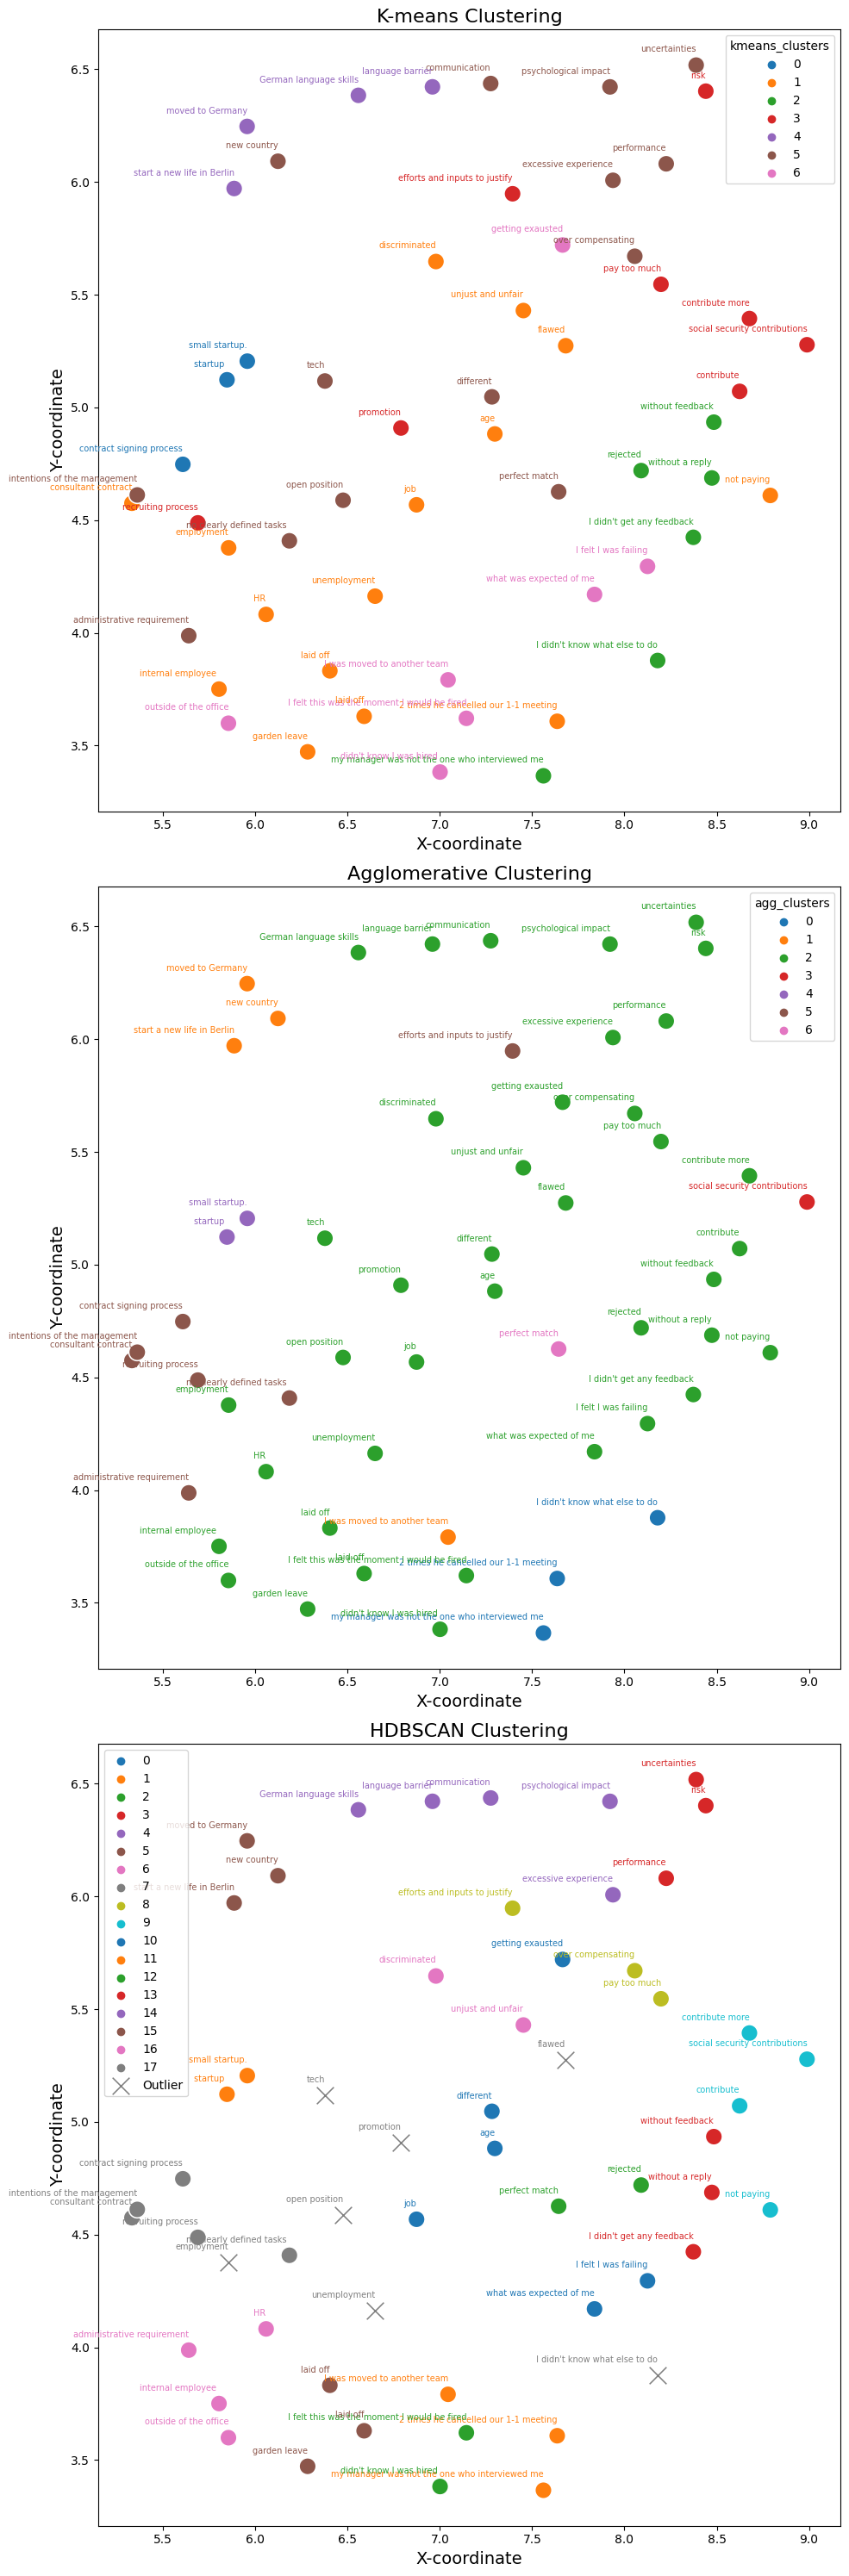

In [ ]:

# @title Compare cluster assignments
fig, axes = plt.subplots(3, 1, figsize=(10, 30))

clustering_algorithms = ['kmeans_clusters', 'agg_clusters', 'hdbscan_clusters']
titles = ['K-means Clustering', 'Agglomerative Clustering', 'HDBSCAN Clustering']

# Loop to create scatter plots for each clustering algorithm
for ax, column, title in zip(axes, clustering_algorithms, titles):
    # Determine the number of unique clusters (ignoring outliers for HDBSCAN)
    n_clusters = len(tag_df[tag_df[column] != -1][column].unique())

    # Generate color palette
    palette = sns.color_palette('tab10', n_colors=n_clusters)

    # Special handling for HDBSCAN to separate out the outliers (cluster -1)
    if column == 'hdbscan_clusters':
        sns.scatterplot(x='x', y='y', hue=column, palette=palette, data=tag_df[tag_df[column] != -1], s=200, legend="full", marker='o', ax=ax)
        sns.scatterplot(x='x', y='y', color='gray', data=tag_df[tag_df[column] == -1], s=200, marker='x', ax=ax, label='Outlier')
    else:
        sns.scatterplot(x='x', y='y', hue=column, palette=palette, data=tag_df, s=200, legend="full", marker='o', ax=ax)

    # Annotate each point with the tag name, using the same color as the point
    for i in range(tag_df.shape[0]):
        if column == 'hdbscan_clusters' and tag_df[column][i] == -1:
            cluster_color = 'gray'
        else:
            cluster_color = palette[tag_df[column][i] if tag_df[column][i] != -1 else 0]  # Default to first color if index is -1
        ax.text(tag_df.x[i], tag_df.y[i]+0.05, tag_df.tag_name[i], fontsize=7, ha='right', va='bottom', color=cluster_color)

    # Set plot title and labels
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('X-coordinate', fontsize=14)
    ax.set_ylabel('Y-coordinate', fontsize=14)

# Show the plots
plt.tight_layout()
plt.show()


In [ ]:
# @title Save results
tag_df.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis=1).to_csv('/content/drive/Shareddrives/MIGR-AI-TION/research_data/LLM/tag_clustering_results.csv')
tag_df.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis=1).to_json('/content/drive/Shareddrives/MIGR-AI-TION/research_data/LLM/tag_clustering_results.json', orient='records')

## Conclusion
Concluding with picking K-Means as best clustering algorithm.
The clusters are better balanced than others, which will avoid small clusters with low interpretability. Not super well aligned with UMAP projection but the distribution in 2D space will be different in the dashboard.

Pre-selected number of clusters is also preferable to integrate the force layout.